# 实验目的
熟悉掌握数据预处理操作

并采用SVM，决策树和xgboost三种模型对数据进行分类，比较三种模型的分类效果。

In [19]:
# 导入所需的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# 数据预处理
## 读取数据，展示数据信息

训练集信息:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
缺失值数量: PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VI

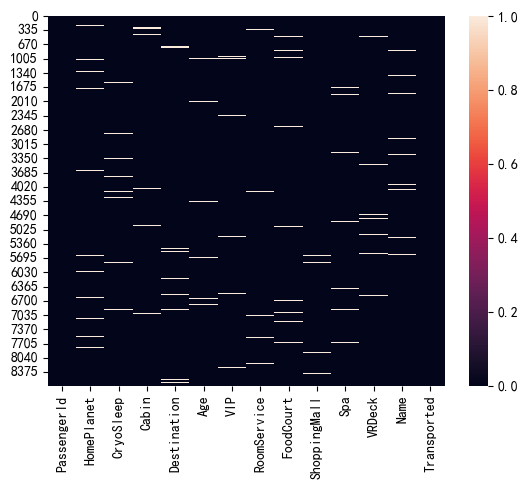

测试集信息:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB
None
缺失值数量: PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt     

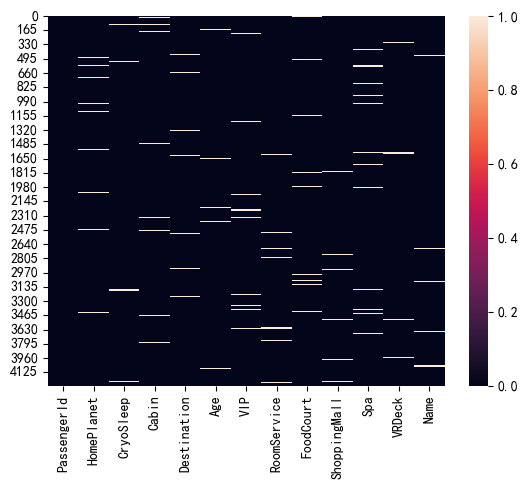

In [5]:
# 读取数据
train = pd.read_csv('spaceship-titanic/train.csv')
test = pd.read_csv('spaceship-titanic/test.csv')

# 查看是否有缺失值和异常值
# 训练集
print('训练集信息:\n')
print(train.info())
print('缺失值数量:', train.isnull().sum())
sns.heatmap(train.isnull())
plt.show()

# 测试集
print('测试集信息:\n')
print(test.info())
print('缺失值数量:', test.isnull().sum())
sns.heatmap(test.isnull())
plt.show()



## 处理缺失值，并进行预处理
对于PassengerId，分离前面的gggg建立新一列room_id，无缺失值

对于HomePlanet，缺失值用最频繁的值填充

对于CryoSleep，当CryoSleep为True时，代表假死状态，不会有后序RoomService&FoodCourt&ShoppingMall&Spa&VRDeck的额外花费，所以将这些值设为0，缺失值用最频繁的值填充

对于cabin，分离为cabin_deck,cabin_num,cabin_side，若cabin为空，则cabin_deck设为空，cabin_num设为空，cabin_side设为空

对于Destination，缺失值用最频繁的值填充

对于Age，缺失值用平均值填充

对于VIP，缺失值用最频繁的值填充

对于RoomService&FoodCourt&ShoppingMall&Spa&VRDeck这几个属性，若为空用平均值填充加起来作为为新的spend属性

对于Name，若Name为空，去除该行

对于cabin_deck，cabin_side这几个属性，缺失值用最频繁的值填充

对于cabin_num，缺失值用平均值填充

为HomePlanet, CryoSleep, Destination, VIP, cabin_deck, cabin_num, cabin_side, Name, room_id这几个属性进行one-hot编码转化

将Transported标签转换为0,1

In [6]:
def data_process(data):
    # 对于PassengerId，分离前面的gggg建立新一列room_id，无缺失值
    data['room_id'] = data['PassengerId'].apply(lambda x: x[:4])
    # 对于HomePlanet，缺失值用最频繁的值填充
    data['HomePlanet'] = data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])
    # 对于CryoSleep，当CryoSleep为True时，代表假死状态，不会有后序RoomService&FoodCourt&ShoppingMall&Spa&VRDeck的额外花费，所以将这些值设为0，缺失值用最频繁的值填充
    data.loc[data['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0
    data['CryoSleep'] = data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])
    # 对于cabin，分离为cabin_deck,cabin_num,cabin_side(使用'/'分离)，若cabin为空，则cabin_deck设为空，cabin_num设为空，cabin_side设为空
    for i in range(len(data)):
        if data.loc[i, 'Cabin'] == data.loc[i, 'Cabin']:
            data.loc[i, 'cabin_deck'] = data.loc[i, 'Cabin'].split('/')[0]
            data.loc[i, 'cabin_num'] = data.loc[i, 'Cabin'].split('/')[1]
            data.loc[i, 'cabin_side'] = data.loc[i, 'Cabin'].split('/')[2]
        else:
            data.loc[i, 'cabin_deck'] = np.nan
            data.loc[i, 'cabin_num'] = np.nan
            data.loc[i, 'cabin_side'] = np.nan
    # 对于Destination，缺失值用最频繁的值填充
    data['Destination'] = data['Destination'].fillna(data['Destination'].mode()[0])
    # 对于Age，缺失值用平均值填充
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    # 对于VIP，缺失值用最频繁的值填充
    data['VIP'] = data['VIP'].fillna(data['VIP'].mode()[0])
    # 对于RoomService&FoodCourt&ShoppingMall&Spa&VRDeck这几个属性，若为空用平均值填充，加起来作为为新的spend属性
    data['RoomService'] = data['RoomService'].fillna(data['RoomService'].mean())
    data['FoodCourt'] = data['FoodCourt'].fillna(data['FoodCourt'].mean())
    data['ShoppingMall'] = data['ShoppingMall'].fillna(data['ShoppingMall'].mean())
    data['Spa'] = data['Spa'].fillna(data['Spa'].mean())
    data['VRDeck'] = data['VRDeck'].fillna(data['VRDeck'].mean())
    data['spend'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
    # 对于Name，若Name为空，设为unknown
    data['Name'] = data['Name'].fillna('unknown')
    # 对于cabin_deck，cabin_side这几个属性，缺失值用最频繁的值填充
    data['cabin_deck'] = data['cabin_deck'].fillna(data['cabin_deck'].mode()[0])
    data['cabin_side'] = data['cabin_side'].fillna(data['cabin_side'].mode()[0])
    # 为HomePlanet, CryoSleep, Destination, VIP, cabin_deck, cabin_num, cabin_side, Name, room_id这几个属性转化为可用的变量
    data['HomePlanet'] = data['HomePlanet'].astype('category')
    data['CryoSleep'] = data['CryoSleep'].astype('category')
    data['Destination'] = data['Destination'].astype('category')
    data['VIP'] = data['VIP'].astype('category')
    data['cabin_deck'] = data['cabin_deck'].astype('category')
    data['cabin_num'] = data['cabin_num'].astype('category')
    data['cabin_side'] = data['cabin_side'].astype('category')
    data['Name'] = data['Name'].astype('category')
    data['room_id'] = data['room_id'].astype('category')

    data['HomePlanet'] = data['HomePlanet'].cat.codes
    data['CryoSleep'] = data['CryoSleep'].cat.codes
    data['Destination'] = data['Destination'].cat.codes
    data['VIP'] = data['VIP'].cat.codes
    data['cabin_deck'] = data['cabin_deck'].cat.codes
    data['cabin_num'] = data['cabin_num'].cat.codes
    data['cabin_side'] = data['cabin_side'].cat.codes
    data['Name'] = data['Name'].cat.codes
    data['room_id'] = data['room_id'].cat.codes
    
    # 若存在Transported标签
    if 'Transported' in data.columns:
        # 将Transported标签转换
        data['Transported'] = data['Transported'].astype('category')
        data['Transported'] = data['Transported'].cat.codes
    return data
train = data_process(train)
test = data_process(test)


## 分析属性与标签的关联程度

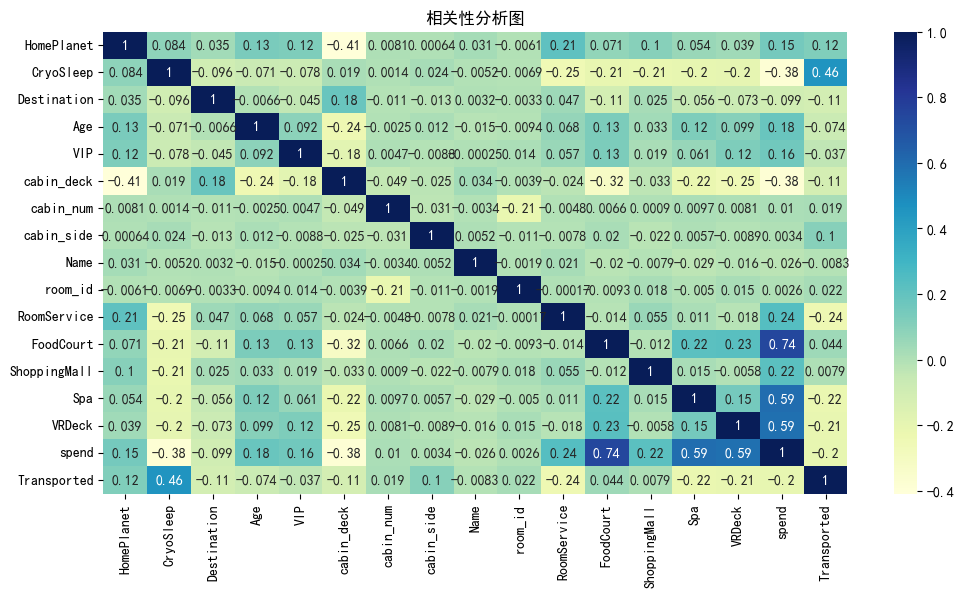

In [7]:

# 去除train中的PassengerId
train.drop(['PassengerId'], axis=1, inplace=True)

df_tmp1 = train[
    ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'cabin_deck', 'cabin_num', 'cabin_side', 'Name', 'room_id', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'spend', 'Transported']]
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
# 图片放大
plt.figure(figsize=(12, 6))
sns.heatmap(df_tmp1.corr(), cmap="YlGnBu", annot=True)
plt.title("相关性分析图")
plt.show()

# 模型设计与选择
使用sklearn中的SVM,决策树和xgBoost

In [8]:
# SVM
def SVM(x_train, y_train, x_test):
    # 建立模型
    clf = SVC()
    clf.fit(x_train, y_train)
    # 预测
    y_pred = clf.predict(x_test)
    return y_pred

# 决策树
def DecisionTree(x_train, y_train, x_test):
    # 建立模型
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    # 预测
    y_pred = clf.predict(x_test)
    return y_pred

# xgBoost
def EI(x_train, y_train, x_test):
    # 建立模型
    clf = XGBClassifier()
    clf.fit(x_train, y_train)
    # 预测
    y_pred = clf.predict(x_test)
    return y_pred

# 预测结果
将预测的True和flase对应乘客id保存到csv文件

In [17]:
# 根据相关性分析图，选择相关性较高的属性

x_train = train[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'cabin_deck', 'cabin_side', 'RoomService', 'Spa', 'VRDeck', 'spend']]
y_train = train['Transported']
x_test = test[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'cabin_deck', 'cabin_side', 'RoomService', 'Spa', 'VRDeck', 'spend']]
# SVM预测
y_pred = SVM(x_train, y_train, x_test)
# 将y_pred变为编码前的值,变为布尔类型
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.replace(0, 'False')
y_pred = y_pred.replace(1, 'True')
# 将test['PassengerId']和y_pred合并, 列标题为PassengerId和Transported
result = pd.concat([test['PassengerId'], y_pred], axis=1)
result.columns = ['PassengerId', 'Transported']
# 保存结果
result.to_csv('result_svm.csv', index=False)

# 决策树预测
y_pred = DecisionTree(x_train, y_train, x_test)
# 将y_pred变为编码前的值
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.replace(0, 'False')
y_pred = y_pred.replace(1, 'True')
# 将test['PassengerId']和y_pred合并, 列标题为PassengerId和Transported
result = pd.concat([test['PassengerId'], y_pred], axis=1)
result.columns = ['PassengerId', 'Transported']
# 保存结果
result.to_csv('result_dt.csv', index=False)

# xgBoost预测
y_pred = EI(x_train, y_train, x_test)
# 将y_pred变为编码前的值
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.replace(0, 'False')
y_pred = y_pred.replace(1, 'True')
# 将test['PassengerId']和y_pred合并, 列标题为PassengerId和Transported
result = pd.concat([test['PassengerId'], y_pred], axis=1)
result.columns = ['PassengerId', 'Transported']
# 保存结果
result.to_csv('result_el.csv', index=False)
